# 1. Data Collection and Manipulation

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image

folder_path = "./archive/"

In [2]:
# Create a df with labels and corresponding image name
csv_file_name = "Training_set.csv"
df = pd.read_csv(os.path.join(folder_path, csv_file_name))

# select only 10-15 class for classification
selected_species = ['CRECENT',
                    'ATALA',
                    'ORANGE TIP',
                    'MOURNING CLOAK', 
                    'MILBERTS TORTOISESHELL',
                    'SCARCE SWALLOW',
                    'SLEEPY ORANGE', 
                    'RED CRACKER',
                    'BANDED ORANGE HELICONIAN', 
                    'BROWN SIPROETA', 
                    ]

df = df[df['label'].str.upper().isin(selected_species)].reset_index(drop=True)
#display(df)

In [3]:
# Check if the image format is valid and verify if TensorFlow can load the image, otherwise mark it as invalid.

images_path = "train"
images_folder_path = os.path.join(folder_path, images_path)
invalid_images = []
dataset = []
target_size = (128, 128)

# I can check all extension supported from PIL 
supported_exts = tuple(ext.lower() for ext in Image.registered_extensions().keys())

for filename in df['filename']:
    file_path = os.path.join(images_folder_path, filename)
    print(filename)
    if os.path.isfile(file_path):
        
        # Check if the file extension is a supported image format
        if not filename.lower().endswith(supported_exts):
            print(f"Invalid Extension for {filename}.")
            invalid_images.append(filename)
            continue

        # Try loading and preprocessing the image
        try:
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=target_size)  # Load the image and resize to the target dimensions
            numeric_img = tf.keras.preprocessing.image.img_to_array(img)  # Convert image to a numeric array
            numeric_img = numeric_img / 255.  # Normalize pixel values to range [0, 1]
            dataset.append(numeric_img)  # Add the preprocessed image to the dataset
        except Exception as e:
            print(f"Error loading {filename}: {e}.")
            invalid_images.append(filename)
    else:
        print(f"Skipping {filename}, not a file.")
print("images checked")
dataset_np = np.array(dataset)

print()
print("Invalid images list:", invalid_images)

# Update the df with valid images only
df = df[~df['filename'].isin(invalid_images)].reset_index(drop=True)


#-------------------------------------------------------------------
# Delete invalid images from disk (uncomment to enable deletion)

# for invalid_file in invalid_images:
#     file_path = os.path.join(images_folder_path, invalid_file)
#     try:
#         os.remove(file_path)
#         print(f"Deleted: {invalid_file}")
#     except Exception as e:
#         print(f"Failed to delete {invalid_file}: {e}")

Image_3.jpg
Image_9.jpg
Image_30.jpg
Image_45.jpg
Image_53.jpg
Image_59.jpg
Image_72.jpg
Image_73.jpg
Image_74.jpg
Image_92.jpg
Image_97.jpg
Image_104.jpg
Image_105.jpg
Image_107.jpg
Image_111.jpg
Image_120.jpg
Image_129.jpg
Image_141.jpg
Image_143.jpg
Image_148.jpg
Image_150.jpg
Image_153.jpg
Image_170.jpg
Image_177.jpg
Image_191.jpg
Image_198.jpg
Image_211.jpg
Image_212.jpg
Image_220.jpg
Image_225.jpg
Image_234.jpg
Image_237.jpg
Image_251.jpg
Image_253.jpg
Image_259.jpg
Image_266.jpg
Image_272.jpg
Image_275.jpg
Image_276.jpg
Image_278.jpg
Image_283.jpg
Image_286.jpg
Image_292.jpg
Image_295.jpg
Image_297.jpg
Image_309.jpg
Image_313.jpg
Image_317.jpg
Image_323.jpg
Image_334.jpg
Image_341.jpg
Image_349.jpg
Image_359.jpg
Image_373.jpg
Image_375.jpg
Image_380.jpg
Image_381.jpg
Image_382.jpg
Image_391.jpg
Image_397.jpg
Image_398.jpg
Image_403.jpg
Image_406.jpg
Image_408.jpg
Image_413.jpg
Image_430.jpg
Image_443.jpg
Image_448.jpg
Image_454.jpg
Image_458.jpg
Image_471.jpg
Image_472.jpg
Image

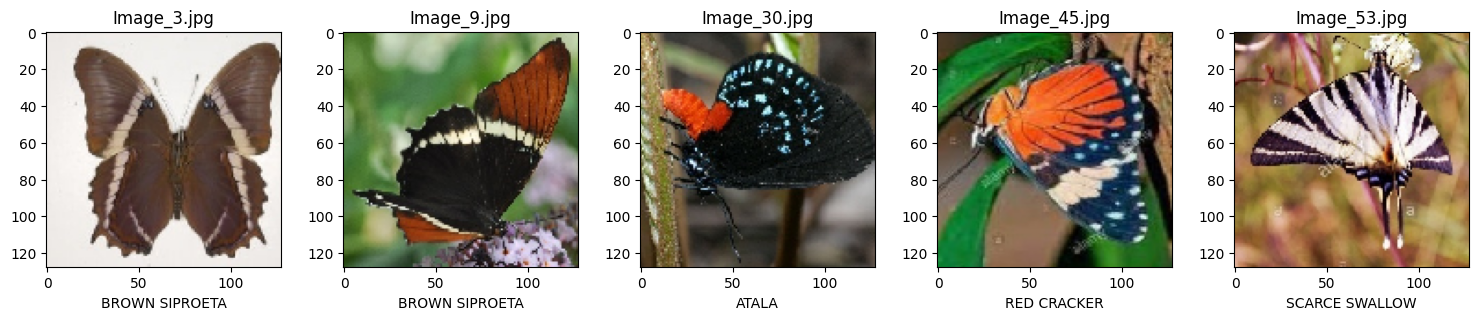

In [4]:
# check on dataset grid
img_index = 0
plt.figure(figsize=(15, 3))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(dataset_np[img_index + i])
    plt.xlabel(df.loc[img_index + i, 'label'])
    plt.title(df.loc[img_index + i, 'filename'])

plt.tight_layout()
plt.show()

In [5]:
# Create array for labels
labels = df['label'].values

# change from string label to numeric label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

### Train Validation and Test
A split of 70% training, 15% validation, and 15% testing is chosen. The training and validation sets are used to fit the model and prevent overfitting, while the test set provides an unbiased assessment of the modelâ€™s performance.

In [6]:
#default shuffle is true, stratify=labels_encoded, stratify=y_temp

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    dataset_np, labels_encoded, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42) # here test size is to ensure that is 15% of total, so 17.6% of 85% of total

# 2. Model Creation and Optimization

- numero di layers
- kernel size
- batch size
- dropout
- lr
- l2r

In [7]:
print("shape of X_train: ",X_train.shape)
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (target_size[0], target_size[1], 3)
number_of_classes = len(selected_species)

shape of X_train:  (711, 128, 128, 3)


### Generic parametric function

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers

# Generic parametric function to create the model
def build_cnn_model(
    input_shape,
    number_of_classes,
    kernel_size=(3, 3),     
    num_layers=3,       
    learning_rate=0.001,    
    l2_reg=0.0,             
    dropout_rate=0.0        
):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    if num_layers == 1:
        # 1 conv layer 32 filters
        model.add(layers.Conv2D(32, kernel_size, activation='relu',kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.MaxPooling2D((2, 2)))

    elif num_layers == 2:
        # 2 conv layer 32, 64 filters
        model.add(layers.Conv2D(32, kernel_size, activation='relu',kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, kernel_size, activation='relu',kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.MaxPooling2D((2, 2)))

    elif num_layers == 3:
        # 3 conv layer 32, 64, 64 filters
        model.add(layers.Conv2D(32, kernel_size, activation='relu',kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, kernel_size, activation='relu',kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, kernel_size, activation='relu',kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg)
    ))

    model.add(layers.Dense(number_of_classes))

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model


## 2.1 Selecting Architecture
### Number of Convolutional layers

In [ ]:
# Choose btw 3 types of architectures: 1, 2, or 3 Conv2D layers.
# setting overall variables

num_try = 3
CNN_s = [None] * num_try
history = [None] * num_try
names = ["1 layer 64", "2 layers 32-64", "3 layers 32-64-64"]
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
epochs = 100
batch_size = 32
best_val_acc = 0.

# fixing random seed for better reproducibility
seed_value = 42
import random
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

for i in range(num_try):
    # create model
    CNN_s[i] = build_cnn_model(input_shape, number_of_classes, num_layers=i+1)

    # train all nets
    history[i] = CNN_s[i].fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        batch_size=batch_size,
        verbose=0
    )
    best_epoch = history[i].history['val_loss'].index(min(history[i].history['val_loss']))
    train_acc_best = history[i].history['accuracy'][best_epoch]
    val_acc_best = history[i].history['val_accuracy'][best_epoch]
    effective_epochs = best_epoch + 1 # start from 0

    print(f"CNN {names[i]}: Epochs={effective_epochs}, Train accuracy={train_acc_best:.5f}, Validation accuracy={val_acc_best:.5f}")

    # check for best model
    if val_acc_best > best_val_acc:
        best_val_acc = val_acc_best
        best_num_layers = i + 1  # num_layers given to build_cnn_model
        best_index = i

print(f"Best model: {names[best_index]}")

# PERCHE? MI VIENE MEGLIO UN SINGOLO LAYER!!!! :( SISTEMAREEEEEEEEEEEEEEEEEEEEEEE

CNN 1 layer 64: Epochs=9, Train accuracy=1.00000, Validation accuracy=0.83553
CNN 2 layers 32-64: Epochs=4, Train accuracy=0.90577, Validation accuracy=0.76316
CNN 3 layers 32-64-64: Epochs=6, Train accuracy=0.90436, Validation accuracy=0.76316
Best model: 1 layer 64


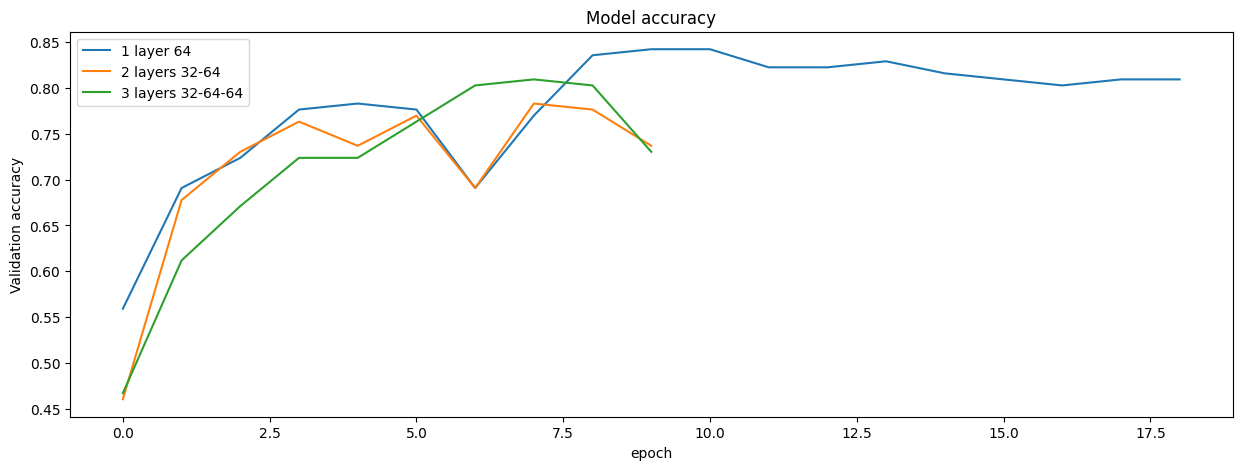

In [ ]:
# accuracy plot
plt.figure(figsize=(15,5))
for i in range(num_try):
    plt.plot(history[i].history['val_accuracy'], label=names[i])
plt.title('Model accuracy')
plt.ylabel('Validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

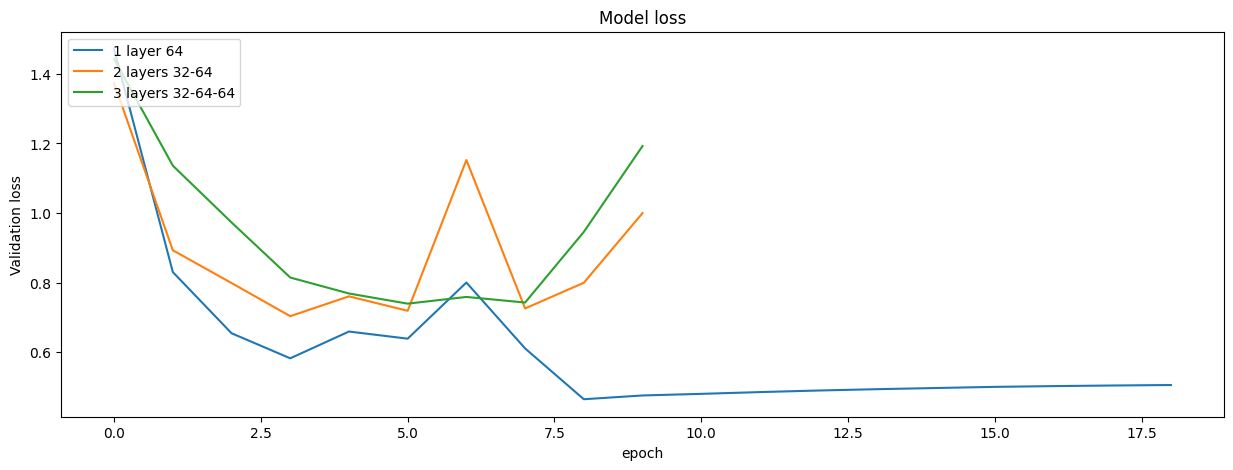

In [11]:
# accuracy plot
plt.figure(figsize=(15,5))
for i in range(num_try):
    plt.plot(history[i].history['val_loss'], label=names[i])
plt.title('Model loss')
plt.ylabel('Validation loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

### Kernel size

choose between 3x3, 5x5 or 7x7

In [12]:
# to be done